# **Imports and Setup**

In [ ]:
import json
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import layers, Model
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **Data Loading and Preparation**

In [ ]:
def encode_text(texts, max_len=128):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )


In [ ]:
# Load the data from your JSON file
with open('Sample data.json') as f:
    data = json.load(f)

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Add a column to indicate if the food is healthy based on some criteria
df['is_healthy'] = df['user_rating'].apply(lambda x: 1 if x > 4.5 else 0)

# Combine 'Name' and 'Ingredients' for text input
df['text'] = df['food_name'] + ' ' + df['ingredients'].apply(lambda x: ' '.join(x))


# **Text Tokenization and Encoding**

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
def encode_text(texts, max_len=128):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Convert 'text' column to a list of strings
text_list = df['text'].astype(str).tolist()

# Encode the text data
encoded_texts = encode_text(text_list)

# Convert TensorFlow tensors to numpy arrays
X_ids = encoded_texts['input_ids'].numpy()
X_mask = encoded_texts['attention_mask'].numpy()
y = df['is_healthy'].values

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# **Data Splitting**

In [ ]:
# Prepare training and validation data
X_train_ids, X_val_ids, X_train_mask, X_val_mask, y_train, y_val = train_test_split(
    X_ids, X_mask, y, test_size=0.2, random_state=42
)


# **Model Building**

In [ ]:
# Define a custom Keras layer that wraps the TFBertModel
class BertLayer(layers.Layer):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(BertLayer, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return pooled_output

# Define input layers
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Use the custom BERT layer
bert_output = BertLayer()([input_ids, attention_mask])

# Add additional layers for classification
dropout = layers.Dropout(0.3)(bert_output)
dense = layers.Dense(64, activation='relu')(dropout)
output = layers.Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 768)            │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=df['is_healthy'].unique(),
    y=df['is_healthy']
)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    [X_train_ids, X_train_mask],
    y_train,
    epochs=10,
    batch_size=16,
    validation_data=([X_val_ids, X_val_mask], y_val),
    class_weight=class_weights
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 114s 10s/step - accuracy: 0.3253 - loss: 0.7824 - val_accuracy: 0.2432 - val_loss: 0.9343
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.3228 - loss: 0.7626 - val_accuracy: 0.2432 - val_loss: 0.8577
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.4364 - loss: 0.7540 - val_accuracy: 0.2432 - val_loss: 0.8033
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.4838 - loss: 0.6994 - val_accuracy: 0.2432 - val_loss: 0.7661
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 91s 9s/step - accuracy: 0.4212 - loss: 0.8146 - val_accuracy: 0.2432 - val_loss: 0.7490
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 88s 9s/step - accuracy: 0.4986 - loss: 0.7559 - val_accuracy: 0.2703 - val_loss: 0.7310
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 86s 9s/step - accuracy: 0.4985 - loss: 0.7484 - val_accuracy: 0.2432 - val_loss: 0.7385
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 9s/step - accuracy: 0.5498 - loss: 0.6958 - val_accuracy: 0.2432 - val_

# **Model Evaluation**

In [ ]:
# Evaluate the model on validation set
loss, accuracy = model.evaluate([X_val_ids, X_val_mask], y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Predict on validation set
y_pred_probs = model.predict([X_val_ids, X_val_mask])
y_pred = (y_pred_probs > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Not Healthy', 'Healthy']))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)


2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.2455 - loss: 0.7728
Validation Loss: 0.77245032787323
Validation Accuracy: 0.2432432472705841
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step

Classification Report:
              precision    recall  f1-score   support

 Not Healthy       0.24      1.00      0.39         9
     Healthy       0.00      0.00      0.00        28

    accuracy                           0.24        37
   macro avg       0.12      0.50      0.20        37
weighted avg       0.06      0.24      0.10        37


Confusion Matrix:
[[ 9  0]
 [28  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Visualization**

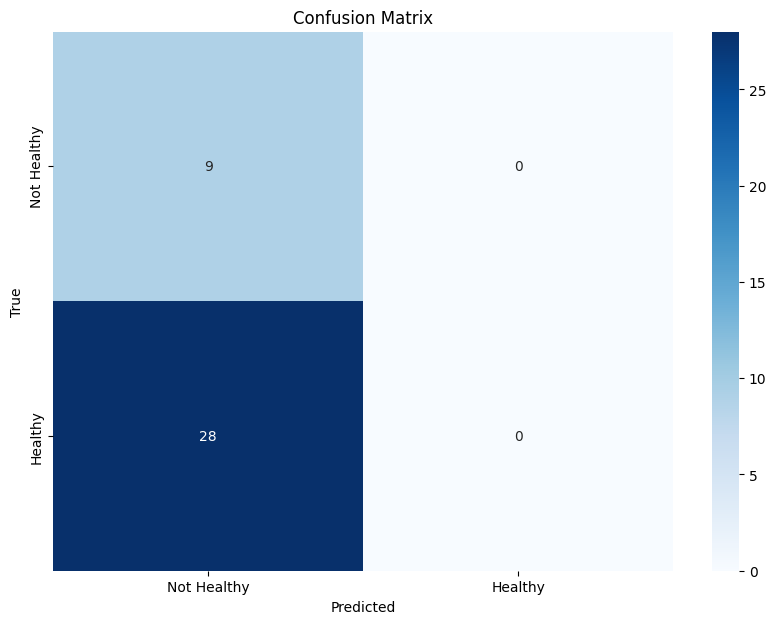

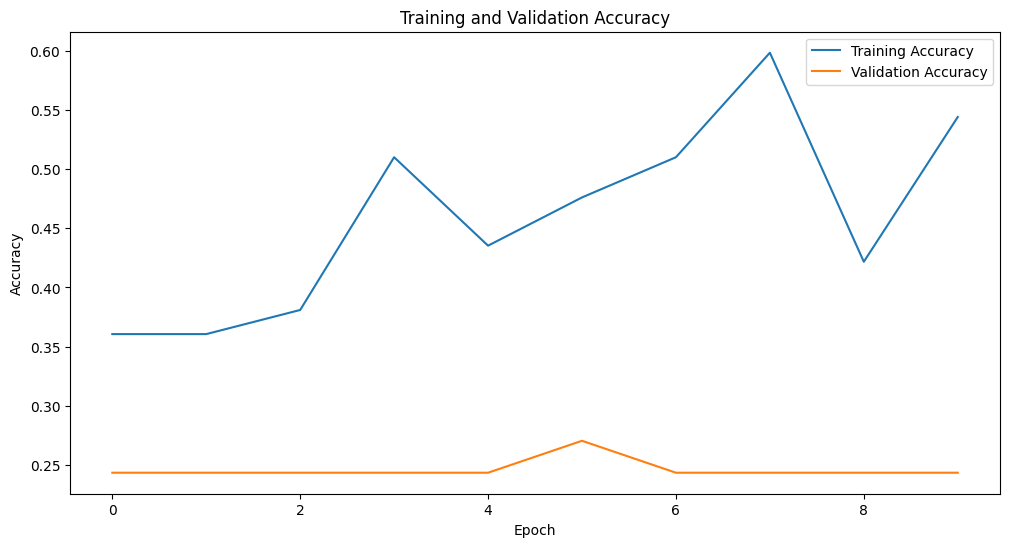

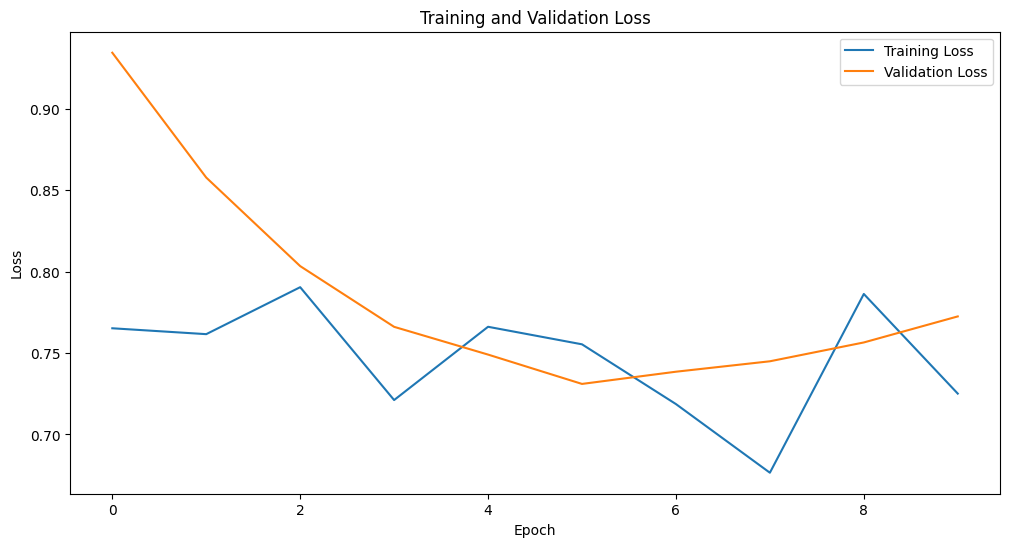

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Healthy', 'Healthy'],
            yticklabels=['Not Healthy', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# **Prediction Functions**

In [ ]:
# Define a function to get ingredients
def get_ingredients(food_name, df):
    match = df[df['food_name'].str.lower() == food_name.lower()]
    if not match.empty:
        return match.iloc[0]['ingredients']
    else:
        return "Food name not found in the database."

# Define a function to predict healthiness
def predict_healthiness(food_name, model, tokenizer, df, max_len=128):
    text = food_name
    encoded_text = encode_text([text], max_len)
    prediction = model.predict([encoded_text['input_ids'].numpy(), encoded_text['attention_mask'].numpy()])
    is_healthy = prediction[0][0] > 0.5
    ingredients = get_ingredients(food_name, df)
    return is_healthy, ingredients


# **Main Function**

In [ ]:
# Main function to input food name and get results
def main():
    food_name = input("Enter the food name: ")
    is_healthy, ingredients = predict_healthiness(food_name, model, tokenizer, df)
    print(f"Food Name: {food_name}")
    print(f"Healthy: {'Yes' if is_healthy else 'No'}")
    print("Ingredients:", ingredients)

# Run the main function
main()
